### Week 9 - Dimensionality Reduction

Welcome to the Week 9 Lab! In this lab, we will explore dimensionality reduction, a topic that you may have encountered in discussions on regularization. Specifically, we will focus on Principal Component Analysis (PCA). Our emphasis will be on the practical implementation of PCA, while the theoretical aspects will be covered in the lecture.

### What is PCA?

Principal Component Analysis (PCA) is a dimensionality reduction technique that is particularly useful for large datasets. It transforms the original variables into principal components, which retain most of the original information while reducing the number of variables. Datasets can easily contain hundreds or even thousands of dimensions. For instance, when assessing risks related to issuing loans, there are multiple dimensions such as credit score, income, experience, repayments, and more. Additionally, we intuitively understand that some dimensions are more important than others. PCA is a mathematical technique that helps us identify and focus on these principal components.

PCA is valuable because it simplifies the complexity of high-dimensional data, making it easier to visualize and analyze. By reducing the dimensionality, PCA helps us identify the underlying structure in the data and often improves the performance of machine learning models.




<br>

### Implementing PCA on USArrest Data

For this lab, we will follow through the ISLR dataset to implement Principle Component Analysis. The dataset is available natively through the package and for your convenience, it is also available in our dataset folder. Let's load the dataset and explore it.

In [1]:
library(tidymodels)
library(tidyverse)
library(ISLR2)
library(factoextra)
library(proxy)
library(ggplot2)
library(ggthemr)

ggthemr("fresh")

-- Attaching packages -------------------------------------- tidymodels 1.2.0 --

v broom        1.0.7     v recipes      1.1.0
v dials        1.3.0     v rsample      1.2.1
v dplyr        1.1.4     v tibble       3.2.1
v ggplot2      3.5.1     v tidyr        1.3.1
v infer        1.0.7     v tune         1.2.1
v modeldata    1.4.0     v workflows    1.1.4
v parsnip      1.2.1     v workflowsets 1.1.0
v purrr        1.0.2     v yardstick    1.3.1

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x purrr::discard() masks scales::discard()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
x recipes::step()  masks stats::step()
* Use suppressPackageStartupMessages() to eliminate package startup messages

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0     v readr     2.1.5
v lubridate 1.9.3     v stringr   1.5.1
-- Conflicts ------------------------------------------ tidyverse_co

In [2]:
us_arrests <- as_tibble( USArrests, rownames = "state" )
us_arrests %>% slice_head(n = 10)

state,Murder,Assault,UrbanPop,Rape
<chr>,<dbl>,<int>,<int>,<dbl>
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6
Colorado,7.9,204,78,38.7
Connecticut,3.3,110,77,11.1
Delaware,5.9,238,72,15.8
Florida,15.4,335,80,31.9


In the dataset, we see that we have the number of arrests associated with each of the 50 states in the United States. Now let's briefly examing these dimensions per state.

The code below returns the mean for each numerical dimension. 

In [3]:
us_arrests %>% 
    select(-state) %>%
    map_dfr(mean)

Murder,Assault,UrbanPop,Rape
<dbl>,<dbl>,<dbl>,<dbl>
7.788,170.76,65.54,21.232


Looking closely at the data, we observe that there are vast discrepancies per crime time. For example, rape arrests are more than twice the murder arrests. Similarly, assaults have many more arrests than any other category, often more than three times other arrest. We can also check the variance of the data to see if any of the observations are influenced differently.

In [4]:
us_arrests %>% select(-state) %>% map_dfr(var)

Murder,Assault,UrbanPop,Rape
<dbl>,<dbl>,<dbl>,<dbl>
18.97047,6945.166,209.5188,87.72916


Similarly, we aslo notice large discrepancies in variances across the states on these crime arrests. Perhaps this is not surprising. 

These early observations are useful because they inform us of the fact that if we fail to transform the dataset, we are going to bias the principle component towards assaul that contains most of the variance and observations. 

### Performing PCA with Scaling

To perform PCA, we use the function `prcomp`. The function has an inbuilt scale parameter that if set to true, it performs PCA with the data scaled. The scaling parameter forces the variables to have a mean of zero. Let's implement PCA on the dataset. Notice that we remove the state and only focus on the numerical vairables.

In [5]:
pca_output <- us_arrests %>% 
                select(-state) %>% 
                prcomp(scale = TRUE)

pca_output

Standard deviations (1, .., p=4):
[1] 1.5748783 0.9948694 0.5971291 0.4164494

Rotation (n x k) = (4 x 4):
                PC1        PC2        PC3         PC4
Murder   -0.5358995 -0.4181809  0.3412327  0.64922780
Assault  -0.5831836 -0.1879856  0.2681484 -0.74340748
UrbanPop -0.2781909  0.8728062  0.3780158  0.13387773
Rape     -0.5434321  0.1673186 -0.8177779  0.08902432

The principle component matrix tells us that there are four principle components that office dimensional information. In particularly, the components are a linear combination of variables with the coefficient as the correlation value. The coefficients are also referred to as loadins. 


### Interpreting the Matrix

The numbers (called loadings) indicate the direction and magnitude of each variable’s contribution to a principal component. <br>

Sign (Positive/Negative): A positive number means that the variable contributes positively to the component (as the variable increases, the component score increases), and a negative number means it contributes negatively (as the variable increases, the component score decreases). 


Magnitude: The larger the absolute value of the number, the more that variable contributes to that particular principal component.


#### Specific  Interpretation

PC1:
Murder, Assault, and Rape have large negative loadings, indicating they strongly contribute to PC1 and in a similar direction. <br>
UrbanPop contributes less to PC1 (smaller magnitude).

PC2: UrbanPop has a large positive loading, meaning it strongly influences PC2, while Murder, Assault, and Rape contribute less and in different directions (Murder and Rape contribute negatively; Assault contributes less but still negatively).

PC3:
Rape has a strong negative contribution to PC3, while Murder and UrbanPop have smaller positive contributions.

PC4:
Murder and Assault contribute most strongly but in opposite directions (Murder positively and Assault negatively).

<br>

### Visualizing the PCA Contribution

In the note above, we have shown how to read the data. An easier way to perform the same reading is to visualize that data by component, showing which variable contribute in that capacity to which component. Specifically, we add contribution into percentages to better understand the impact.

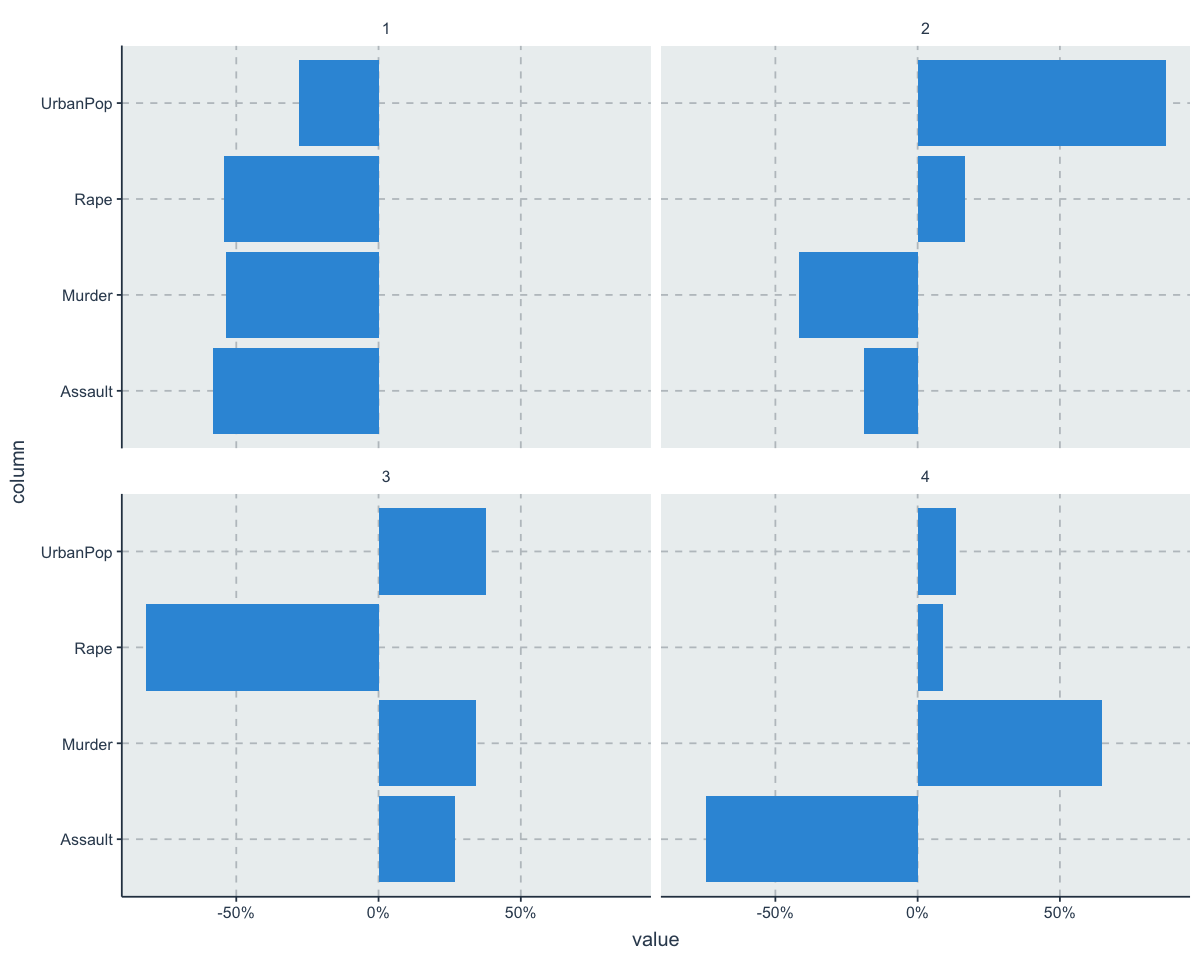

In [6]:
library(ggthemr)
ggthemr("flat")

options(repr.plot.width = 10, repr.plot.height = 8)

tidy(pca_output, matrix = "loadings") %>%
    ggplot(aes(value, column)) + 
    facet_wrap( ~ PC) +
    geom_col() +
    scale_x_continuous( labels = scales::percent )

<br>

### Extracting Matrix Score

The loadings, also referred to as the rotations of the principal components, describe how the original variables contribute to each component. However, we do not use these loadings directly in place of our variables. Instead, we need to extract the scores matrix, which represents the original data transformed into the principal components. These scores can then be used in place of the individual variables. The code below demonstrates how to extract the scores matrix (the original variable values transformed into the components).

In [7]:
augment(pca_output, new_data = us_arrests) %>% 
    slice_head(n = 10)

.rownames,.fittedPC1,.fittedPC2,.fittedPC3,.fittedPC4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.97566045,-1.12200121,0.43980366,0.154696581
2,-1.93053788,-1.06242692,-2.01950027,-0.434175454
3,-1.74544285,0.73845954,-0.05423025,-0.826264240
4,0.13999894,-1.10854226,-0.11342217,-0.180973554
5,-2.49861285,1.52742672,-0.59254100,-0.338559240
6,-1.49934074,0.97762966,-1.08400162,0.001450164
7,1.34499236,1.07798362,0.63679250,-0.117278736
8,-0.04722981,0.32208890,0.71141032,-0.873113315
9,-2.98275967,-0.03883425,0.57103206,-0.095317042


 <br>

We can now use the above components in the modelling process.

### PCA as a Pre-Processing Step

We’ve explored how to implement PCA on a dataset to extract components from the original variables. PCA is often used as a pre-processing step to reduce dimensionality and simplify the data before modeling. When using PCA as a pre-processing step, it's recommended to leverage the `recipes` framework, as it integrates seamlessly with the tidymodels ecosystem. 

The example below demonstrates how to implement PCA using `recipe`.

In [8]:
pca_recipe <- recipe( formula = ~., data = us_arrests ) %>% # use all the columns in the dataset
                step_normalize(all_numeric()) %>%           # implement normalizaiton of the data
                step_pca( all_numeric(), id = 'pca') %>%    # perform pca 
                prep()

pca_recipe %>%
    bake(new_data =  NULL) %>%    # implements pca on the us_arrests original data 
    slice_head(n = 10)

state,PC1,PC2,PC3,PC4
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Alabama,-0.97566045,-1.12200121,0.43980366,0.154696581
Alaska,-1.93053788,-1.06242692,-2.01950027,-0.434175454
Arizona,-1.74544285,0.73845954,-0.05423025,-0.826264240
Arkansas,0.13999894,-1.10854226,-0.11342217,-0.180973554
California,-2.49861285,1.52742672,-0.59254100,-0.338559240
Colorado,-1.49934074,0.97762966,-1.08400162,0.001450164
Connecticut,1.34499236,1.07798362,0.63679250,-0.117278736
Delaware,-0.04722981,0.32208890,0.71141032,-0.873113315
Florida,-2.98275967,-0.03883425,0.57103206,-0.095317042


We can also apply this to new data. For example, lets choose a small subset of us_arrests and apply it.

In [9]:
pca_recipe %>%
    bake(new_data =  us_arrests[32:37, ]) %>%    # implements pca on the us_arrests original data 
    slice_head(n = 10)

state,PC1,PC2,PC3,PC4
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
New York,-1.66566662,0.8149107,0.63661186,-0.01334884
North Carolina,-1.11208808,-2.2056108,0.85489245,-0.94478965
North Dakota,2.96215223,-0.5930974,-0.29824930,-0.25143463
Ohio,0.22369436,0.7347784,0.03082616,0.46915282
Oklahoma,0.30864928,0.2849611,0.01515592,0.01022848
Oregon,-0.05852787,0.5359700,-0.93038718,-0.23539087


We can also retrive the information as we did with the `prcomp()` function using the command below.

In [10]:
tidy(pca_recipe, id = "pca", type = "coef")

terms,value,component,id
<chr>,<dbl>,<chr>,<chr>
Murder,-0.53589947,PC1,pca
Assault,-0.58318363,PC1,pca
UrbanPop,-0.27819087,PC1,pca
Rape,-0.54343209,PC1,pca
Murder,-0.41818087,PC2,pca
Assault,-0.18798560,PC2,pca
UrbanPop,0.87280619,PC2,pca
Rape,0.16731864,PC2,pca
Murder,0.34123273,PC3,pca


### Specifying Thresholds for Components

As we have seen, the loadings are returned and it is up to use to intepret them. Often times, we may wish to restrict the threshold of the component's linear correlation. In this instance, we can set a threshold. In the example below, we repeat the above process and set up a threshold of .7.

In [11]:
recipe( formula = ~., data = us_arrests ) %>%                               # use all the columns in the dataset
                step_normalize(all_numeric()) %>%                           # implement normalizaiton of the data
                step_pca( all_numeric(), id = 'pca', threshold = .7) %>%    # perform pca 
                prep() %>% 
                bake( new_data = NULL ) %>%
                slice_head(n = 20)


state,PC1,PC2
<fct>,<dbl>,<dbl>
Alabama,-0.97566045,-1.12200121
Alaska,-1.93053788,-1.06242692
Arizona,-1.74544285,0.73845954
Arkansas,0.13999894,-1.10854226
California,-2.49861285,1.52742672
Colorado,-1.49934074,0.97762966
Connecticut,1.34499236,1.07798362
Delaware,-0.04722981,0.32208890
Florida,-2.98275967,-0.03883425


As you can see now, we have two components instead of 4 as was the previous case.

This concludes our lab on Principle Component Analysis.

Referrences:

1. ISLR Chapter 12
2. ISLR Tidyverse: https://emilhvitfeldt.github.io/ISLR-tidymodels-labs/12-unsupervised-learning.html